# Training datasets performance

In [1]:
import pandas as pd

# Data import

FE = 0 # Feature Engineering (0 = No, 1 = Yes)
Out = 0 # Outliers Processing (0 = No, 1 = Yes)
FR = 0 # Feature Reduction (0 = No, 1 = Yes)

def dataset(FE, Out, FR):
    if FR == 0:
        if FE == 0:
            if Out == 0:
                X_train = pd.read_csv('data/X_train.csv') # Training data
            else:
                X_train = pd.read_csv('data/X_train_out.csv')
            X_test = pd.read_csv('data/X_test.csv') # Test data
        else:
            if Out == 0:
                X_train = pd.read_csv('data/X_train_FE.csv')
            else:
                X_train = pd.read_csv('data/X_train_FE_out.csv')
            X_test = pd.read_csv('data/X_test_FE.csv') # Test data
    else:
        X_train = pd.read_csv('data/X_train_FR.csv')
        X_test = pd.read_csv('data/X_test_FR.csv') # Test data
    
    return X_train, X_test


In [5]:
X_train, X_test = dataset(FE = 1, Out = 0, FR = 0)

y_train = X_train['Age']
X_train = X_train.drop(['Age'], axis=1)

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_SS= scaler.fit_transform(X_train)

In [319]:
Train_sets = {'Normal dataset': [0, 0, 0], 'Normal dataset without outliers': [0, 1, 0], 
              'Dataset With FE': [1, 0, 0], 'Dataset With FE without outliers': [1, 1, 0],
              'Dataset With FE and FR': [1, 1, 1]}

In [320]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb

Scores = {}

best ={'colsample_bytree': 0.7857887738902785, 
       'learning_rate': 0.03258780738912802, 
       'max_depth': 8, 
       'min_child_samples': 55, 
       'n_estimators': 240, 
       'num_leaves': 79, 
       'reg_alpha': 0.5301178811425332, 
       'reg_lambda': 0.028710808153810163, 
       'subsample': 0.8851558334026159}

for name, model in Train_sets.items():
    X_train, X_test  = dataset(model[0], model[1], model[2])
    y_train = X_train['Age']
    X_train = X_train.drop(['Age'], axis=1)
    model_LGBM = lgb.LGBMRegressor(**best)                   
    mae = cross_val_score(model_LGBM, X_train, y_train, cv=10, scoring=make_scorer(mean_absolute_error)).mean()
    print("Name:", name, "MAE:", mae)
    print('')   

Name: Normal dataset MAE: 1.3971801139692366



# LightGBM model training: First shoot

In [ ]:
# Due to the same Mae in dataset without otuliers and dataset with FE and without outliers, we will use the dataset with FE and without outliers.

# Step 1: Find coincidence between X_original and X_test and fill those 'Age' values in the case
# Step 2: Split the remaining observations of X_test in two datasets: X_test with outliers and X_test without outliers
# Step 3: Train a model for each of these datasets: X_test with outliers and X_test without outliers. Predict 'Age' for each of these datasets.
# Step 4: Merge the two datasets and sort them by 'ID, and merge again with the original dataset.

## Step 1: Fill coincidences betweeen X_test and X_original

In [2]:
# Data import 
X_original = pd.read_csv('input/CrabAgePrediction.csv')
X_train, X_test  = dataset(0, 0, 0)

In [3]:
# Step 1: Find coincidence between X_original and X_test and fill those 'Age' values in the case
X_test_coinc= X_test.loc[:, ["Length", "Diameter", "Height", "Weight", "Shucked Weight", "Viscera Weight","Shell Weight"]]
X_original.drop(['Sex'], axis=1, inplace=True)

# Add the 'Age' column to X_test
columns_without_age = [col for col in X_test_coinc.columns]

# Find coincidence between X_original and X_test and fill those 'Age' values in the case, in the rest Nan values
X_test_coinc = X_test_coinc.merge(X_original, how='left', on=columns_without_age)

In [4]:
# Example of coincidence
X_test_coinc.iloc[28:32]

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
28,1.2500,1.0000,0.3000,16.074167,7.101550,4.436697,4.961163,NaN
29,1.8375,1.4875,0.4500,53.297060,25.783870,11.765042,13.891255,NaN
30,1.6250,1.3000,0.3875,38.782116,17.534166,8.164656,10.347568,9.0
31,1.7625,1.4000,0.3875,47.485413,22.594552,11.609120,10.999606,NaN


In [5]:
# Paso 2: Entrenar un modelo LightGBM en las filas de X_test que aún tienen 'Age' como NaN
# Primero, divide X_test en dos: filas con 'Age' y filas sin 'Age'
X_test_with_age = X_test_coinc.dropna(subset=['Age'])
X_test_without_age = X_test_coinc[X_test_coinc['Age'].isna()]
# Shapes of datasets
print('X_test_with_age shape: ', X_test_with_age.shape)
print('X_test_without_age shape: ', X_test_without_age.shape)


X_test_with_age shape:  (1152, 8)
X_test_without_age shape:  (48216, 8)


In [6]:
X_test.shape

(49368, 10)

In [7]:
# In 1152 observations have been found a coincidence between the values of the variables 'Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight', 'Viscera Weight' and 'Shell Weight' of the dataset X_test and X_original.
# Now we have two datasets: X_test_with_age and X_test_without_age. X_test_without_age is to be trainned.

In [8]:
# New dataset X that is X_test but whitout X_test_with_age observations
X = X_test.drop(X_test_with_age.index)

In [9]:
X.shape

(48216, 10)

## Step 2: Test dataset split 

In [4]:
X_train, X =dataset(0, 0, 0)

In [5]:
X_train.head()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,Sex_F,Sex_I,Sex_M
0,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9,0,1,0
1,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8,0,1,0
2,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9,0,0,1
3,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11,1,0,0
4,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8,0,1,0


In [6]:
SD = 3 # Standard Deviation

X_test_normal = X.copy()
X_test_out = pd.DataFrame()

for col in X.columns[1:]:
    # Define the condition for a value to be considered as an outlier
    condition = (X_test_normal[col] < X_test_normal[col].mean() - SD * X_test_normal[col].std()) | (X_test_normal[col] > X_test_normal[col].mean() + SD * X_test_normal[col].std())
    
    # Add outliers to X_test_out
    X_test_out = pd.concat([X_test_out, X_test_normal[condition]])
    
    # Remove outliers from X_test_normal
    X_test_normal = X_test_normal[~condition]

# The same for X_train
X_train_normal = X_train.copy()
X_train_out = pd.DataFrame()

for col in X_train.columns[1:]:

    condition = (X_train_normal[col] < X_train_normal[col].mean() - SD * X_train_normal[col].std()) | (X_train_normal[col] > X_train_normal[col].mean() + SD * X_train_normal[col].std())
    
    X_train_out = pd.concat([X_train_out, X_train_normal[condition]])
    
    X_train_normal = X_train_normal[~condition]

In [7]:
# Print shapes of datasets
print('X_test_normal shape: ', X_test_normal.shape)
print('X_test_out shape: ', X_test_out.shape)
print('X shape: ', X.shape)

print('X_train_normal shape: ', X_train_normal.shape)
print('X_train_out shape: ', X_train_out.shape)
print('X_train shape: ', X_train.shape)

X_test_normal shape:  (48597, 10)
X_test_out shape:  (771, 10)
X shape:  (49368, 10)
X_train_normal shape:  (72039, 11)
X_train_out shape:  (2012, 11)
X_train shape:  (74051, 11)


## Step 3: Modelling 

### Modelling no outliers observations of test

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb


best ={'colsample_bytree': 0.7857887738902785, 
       'learning_rate': 0.03258780738912802, 
       'max_depth': 8, 
       'min_child_samples': 55, 
       'n_estimators': 240, 
       'num_leaves': 79, 
       'reg_alpha': 0.5301178811425332, 
       'reg_lambda': 0.028710808153810163, 
       'subsample': 0.8851558334026159}


y_train_norm = X_train_normal['Age']
X_train_norm = X_train_normal.drop(['Age'], axis=1)
model_LGBM = lgb.LGBMRegressor(**best)                   
mae = cross_val_score(model_LGBM, X_train_norm, y_train_norm, cv=10, scoring=make_scorer(mean_absolute_error)).mean()
print("MAE:", mae)

MAE: 1.3006518079215716


In [9]:
import numpy as np
import pandas as pd

y_pred_normal = np.round(model_LGBM.fit(X_train_norm, y_train_norm).predict(X_test_normal),0)
y_pred_normal = pd.DataFrame(y_pred_normal, columns=['Age'])

In [10]:
# Concatenate y_pred_normal and X_test_normal
y_pred_new = pd.DataFrame(data=y_pred_normal.values, index=X_test_normal.index, columns=y_pred_normal.columns)
X_test_n = pd.concat([X_test_normal,y_pred_new], axis=1)

### Modelling outliers observations of test

In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb


best ={'colsample_bytree': 0.7857887738902785, 
       'learning_rate': 0.03258780738912802, 
       'max_depth': 8, 
       'min_child_samples': 55, 
       'n_estimators': 240, 
       'num_leaves': 79, 
       'reg_alpha': 0.5301178811425332, 
       'reg_lambda': 0.028710808153810163, 
       'subsample': 0.8851558334026159}


y_train_at = X_train['Age']
X_train_at = X_train.drop(['Age'], axis=1)
model_LGBM_aty= lgb.LGBMRegressor(**best)                   
mae = cross_val_score(model_LGBM_aty, X_train_at, y_train_at, cv=10, scoring=make_scorer(mean_absolute_error)).mean()
print("MAE:", mae)

MAE: 1.3971801139692366


In [13]:
y_pred_aty = np.round(model_LGBM_aty.fit(X_train_at, y_train_at).predict(X_test_out),0)

In [14]:
y_A = pd.DataFrame(y_pred_aty, columns=['Age'])

In [15]:
y_A_new = pd.DataFrame(data=y_A.values, index=X_test_out.index, columns=y_A.columns)
X_test_aty = pd.concat([X_test_out, y_A_new], axis=1).sort_index()

In [16]:
# Conactenate X_test_normal and X_test_out keeping previous order
X_test_remain = pd.concat([X_test_n, X_test_aty]).sort_index()

In [17]:
X_test_remain.shape

(49368, 11)

In [23]:
X_test_remain.head()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Sex_F,Sex_I,Sex_M,Age
0,1.0500,0.7625,0.2750,8.618248,3.657085,1.729319,2.721552,0,1,0,8.0
1,1.1625,0.8875,0.2750,15.507176,7.030676,3.246018,3.968930,0,1,0,8.0
2,1.2875,0.9875,0.3250,14.571643,5.556502,3.883882,4.819415,1,0,0,11.0
3,1.5500,0.9875,0.3875,28.377849,13.380964,6.548735,7.030676,1,0,0,10.0
4,1.1125,0.8500,0.2625,11.765042,5.528153,2.466407,3.331066,0,1,0,7.0


## Step 4: Merge to form X_test original dataset

In [25]:
# Combina X_test_with_age y X_test_without_age de nuevo en X_test
X_test_final = pd.concat([X_test_with_age, X_test_remain]).sort_index()

In [26]:
X_test_final.head()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,Sex_F,Sex_I,Sex_M
0,1.0500,0.7625,0.2750,8.618248,3.657085,1.729319,2.721552,8.0,0.0,1.0,0.0
1,1.1625,0.8875,0.2750,15.507176,7.030676,3.246018,3.968930,8.0,0.0,1.0,0.0
2,1.2875,0.9875,0.3250,14.571643,5.556502,3.883882,4.819415,11.0,1.0,0.0,0.0
3,1.5500,0.9875,0.3875,28.377849,13.380964,6.548735,7.030676,10.0,1.0,0.0,0.0
4,1.1125,0.8500,0.2625,11.765042,5.528153,2.466407,3.331066,7.0,0.0,1.0,0.0


In [27]:
X_test.shape

(49368, 10)

# Model Comparison

In [26]:
X_train.head()

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [27]:
# Comparison of the different models with cross validation
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

X_train, X_test = dataset(0,0,0)
y_train = X_train['Age']
X_train = X_train.drop(['Age'], axis=1)

models = [
    ("Linear Regression", LinearRegression()),
    ("Decision Tree", DecisionTreeRegressor()),
    ("Knn", KNeighborsRegressor()),
    ("XGB", XGBRegressor(eval_metric='mae')),
    ("LGBM", LGBMRegressor())
]

cv = KFold(n_splits=5, shuffle=True, random_state=1)  # KFold cross-validator

model_scores = {}

for name, model in models:
    scores = -1 * cross_val_score(model, X_train, y_train, cv = cv, scoring='neg_mean_absolute_error')
    model_scores[name] = scores

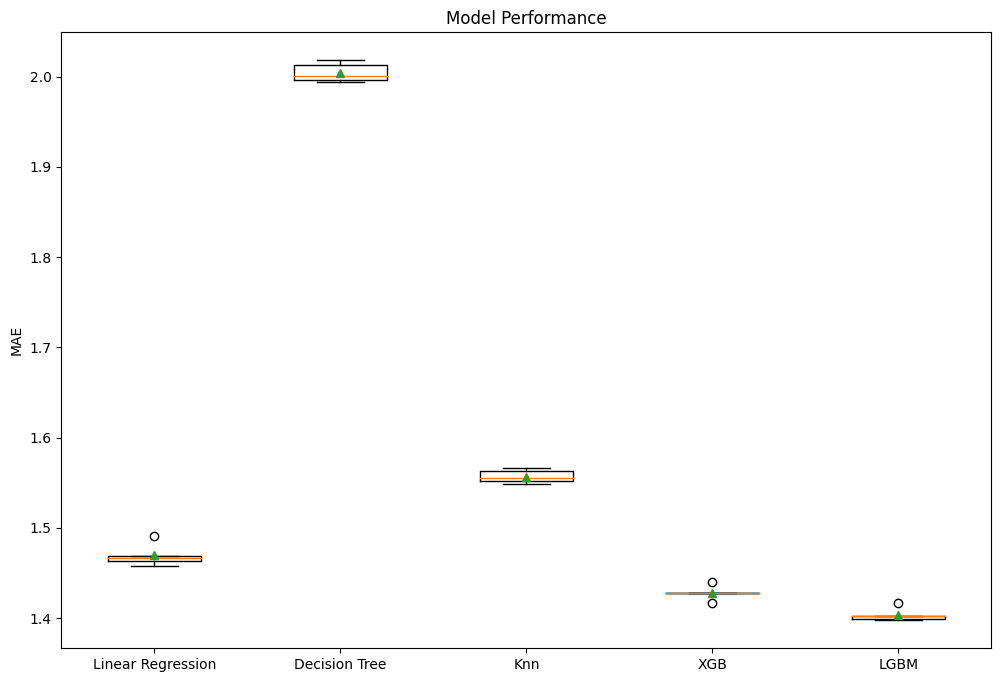

In [ ]:
plt.boxplot(model_scores.values(), labels=model_scores.keys(), showmeans=True)
plt.rcParams['figure.figsize'] = [14, 8] #Size of the plot (width, height)
plt.ylabel("MAE")
plt.title("Model Performance")
plt.show()

# Models training

## Random Forest

In [229]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

# Dividir los datos de entrenamiento en un conjunto de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 25),
    'max_depth': hp.quniform('max_depth', 5, 30, 1),
    'max_features': hp.choice('max_features', [1.0, 'sqrt', 'log2']), # Reemplazado 'auto' por 1.0
    'min_samples_split': hp.quniform('min_samples_split', 2, 20, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1)
}

# Función objetivo para Hyperopt
def objective(params):
    # Convierte los parámetros numéricos a enteros
    params = {'n_estimators': int(params['n_estimators']),
              'max_depth': int(params['max_depth']),
              'max_features': params['max_features'],
              'min_samples_split': int(params['min_samples_split']),
              'min_samples_leaf': int(params['min_samples_leaf'])}

    # Entrenar y predecir con el modelo RandomForestRegressor
    model = RandomForestRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    # Calcular la métrica MAE
    mae = mean_absolute_error(y_val, y_pred)

    return {'loss': mae, 'status': STATUS_OK}

# Ejecutar la optimización de hiperparámetros
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,
            trials=trials)

print("Mejores hiperparámetros encontrados: ", best)


  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

job exception: could not convert string to float: 'M'



  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]


ValueError: could not convert string to float: 'M'

In [43]:
max_features_options = [1.0, 'sqrt', 'log2']  # Las opciones originales para 'max_features'

model_RF = RandomForestRegressor(
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    max_features=max_features_options[best['max_features']],  # Convertir índice a valor
    min_samples_split=int(best['min_samples_split']),
    min_samples_leaf=int(best['min_samples_leaf']),
    random_state=42
)

model_RF.fit(X_train_Modelling_MC, y_train)

RandomForestRegressor(max_depth=13, max_features='log2', min_samples_leaf=6,
                      min_samples_split=3, n_estimators=500, random_state=42)

## Lasso

In [44]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_Modelling_SS = scaler.fit_transform(X_train_Modelling_MC)

In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np

# train test split
X_train, X_val, y_train, y_val = train_test_split(X_train_Modelling_SS, y_train, test_size=0.2, random_state=1)

train_scores = []
val_scores = []

alphas = np.linspace(0.004, 0.8, num=100)


for alpha in alphas:
    model = Lasso(alpha=alpha)
    model.fit(X_train, y_train)
    
    train_score = mean_absolute_error(y_train, model.predict(X_train))
    val_score = mean_absolute_error(y_val, model.predict(X_val))
    
    train_scores.append(train_score)
    val_scores.append(val_score)

# Calculate the difference between training and validation scores
score_diff = [train_scores[i] - val_scores[i] for i in range(len(train_scores))]

# Perform cross-validation
cv_scores = []
for alpha in alphas:
    model = Lasso(alpha=alpha)
    cv_scores.append(-np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')))


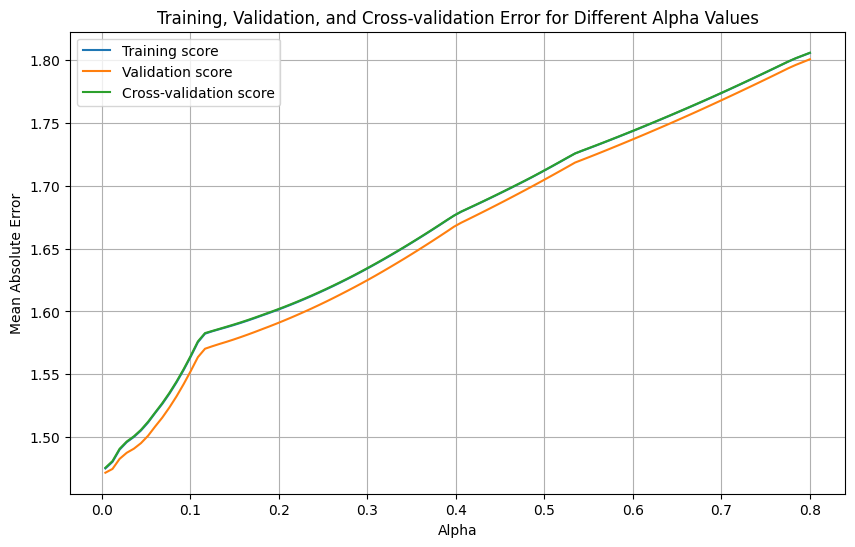

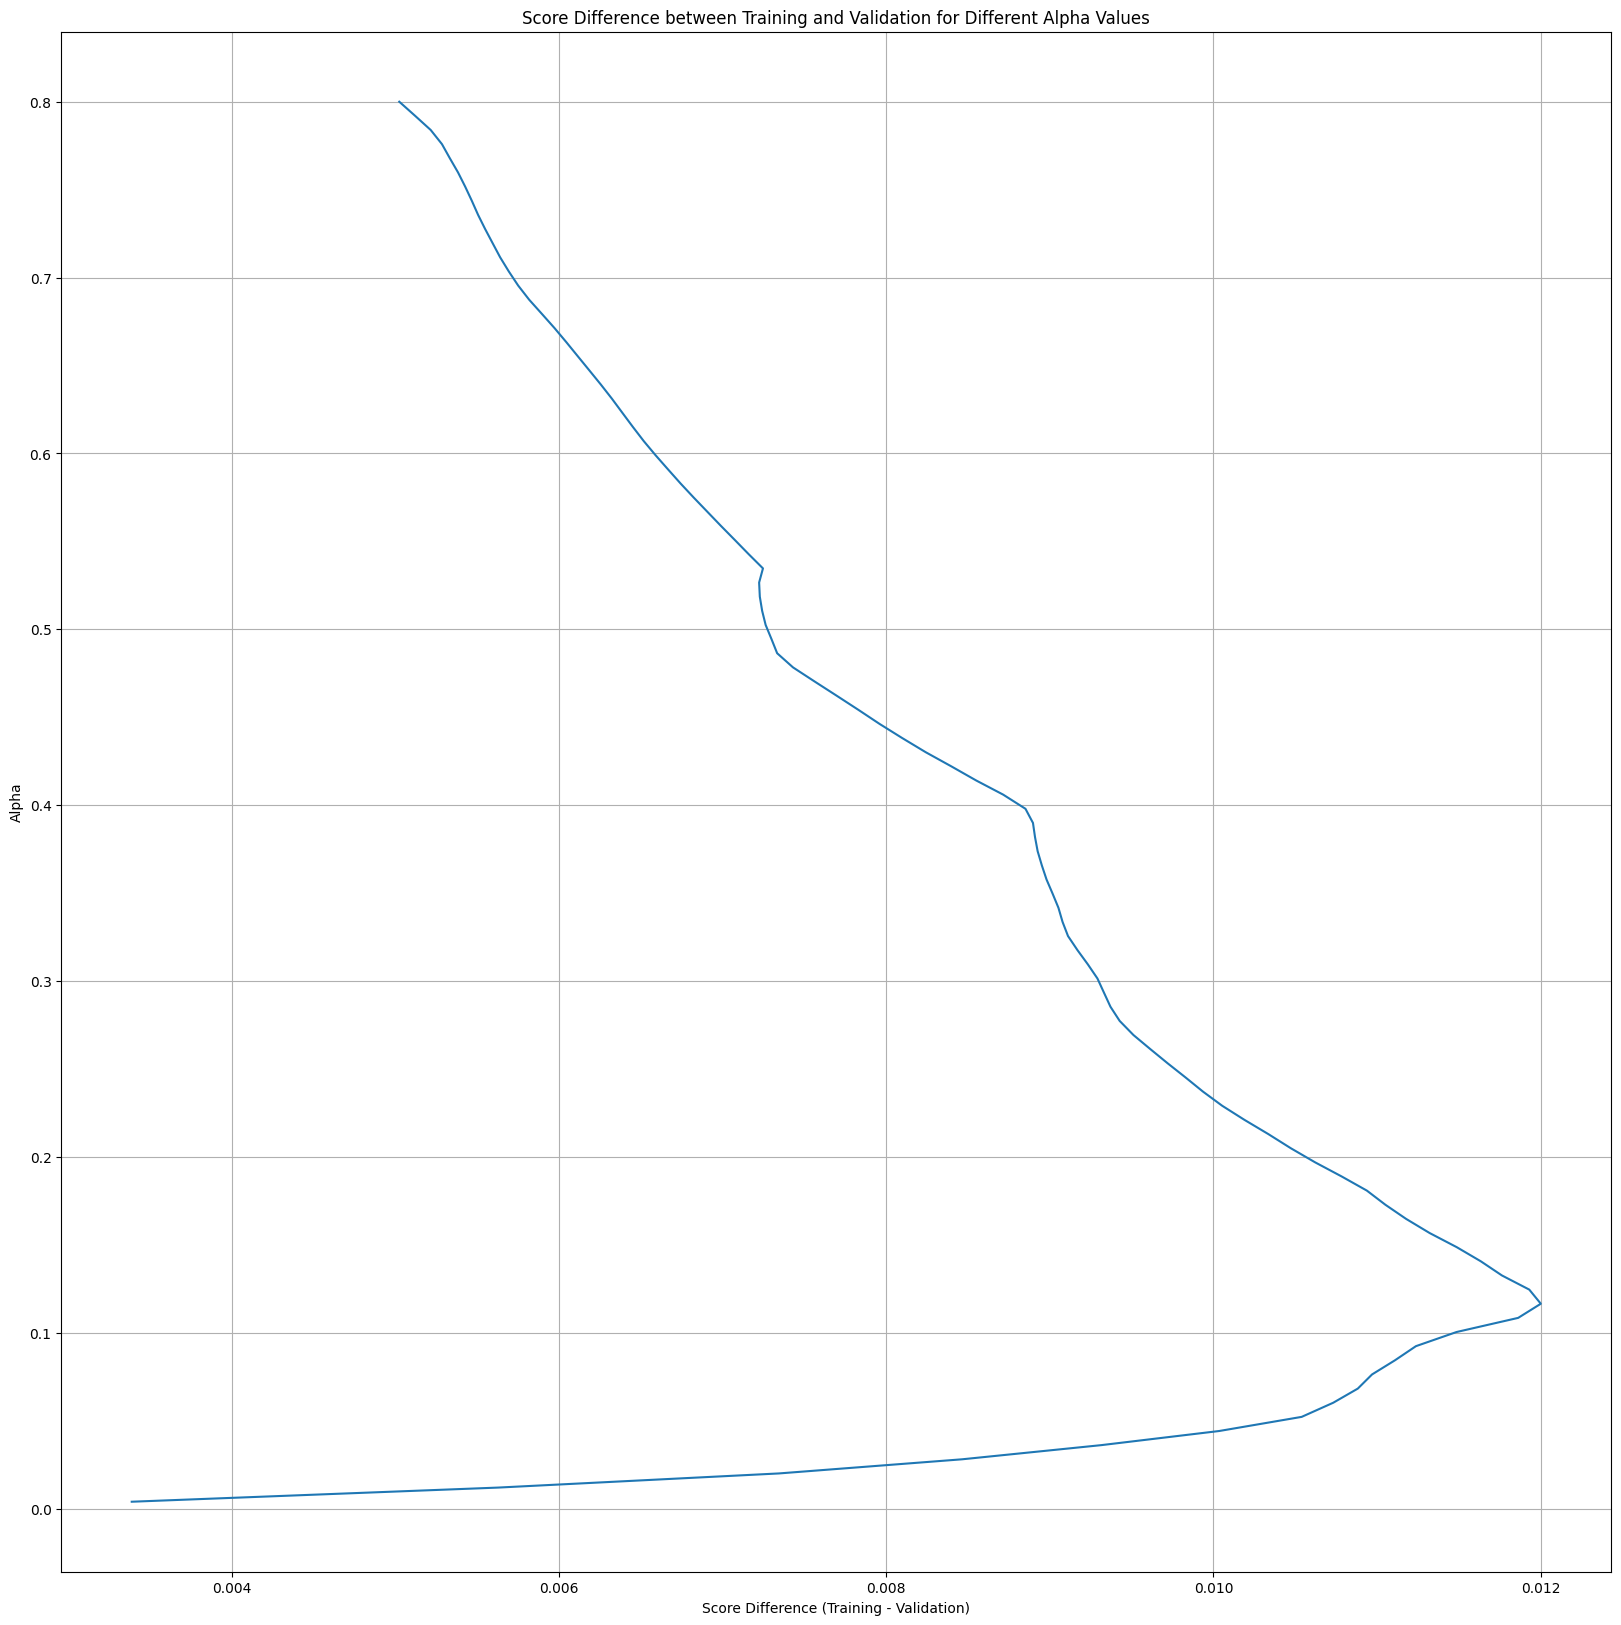

In [46]:

# Plot the scores
plt.figure(figsize=(10,6))
plt.plot(alphas, train_scores, label='Training score')
plt.plot(alphas, val_scores, label='Validation score')
plt.plot(alphas, cv_scores, label='Cross-validation score')
plt.xlabel('Alpha')
plt.ylabel('Mean Absolute Error')
plt.title('Training, Validation, and Cross-validation Error for Different Alpha Values')
plt.legend()
plt.grid()
plt.show()

# Plot the score difference
plt.plot(score_diff, alphas)
plt.ylabel('Alpha')
plt.xlabel('Score Difference (Training - Validation)')
plt.title('Score Difference between Training and Validation for Different Alpha Values')
plt.grid()
plt.show()

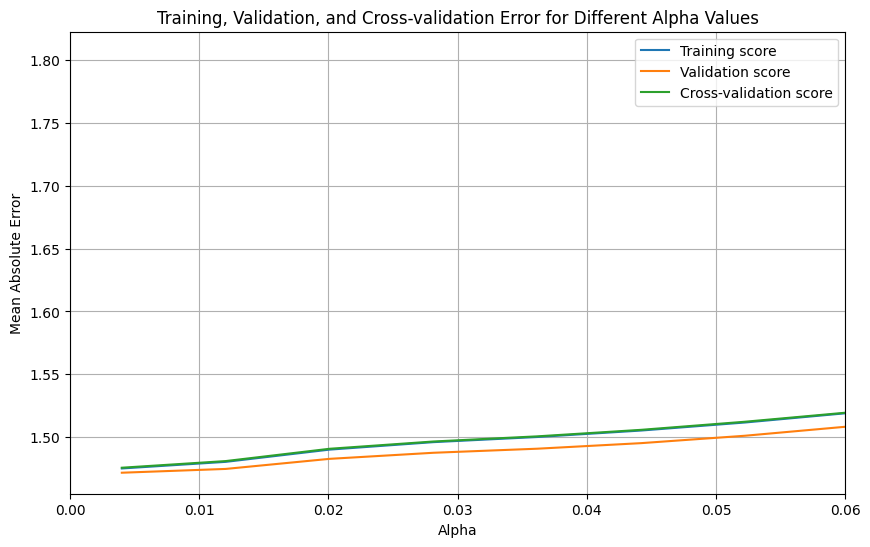

In [68]:
# Plot the scores
plt.figure(figsize=(10,6))
plt.plot(alphas, train_scores, label='Training score')
plt.plot(alphas, val_scores, label='Validation score')
plt.plot(alphas, cv_scores, label='Cross-validation score')
plt.xlim(0, 0.06)




plt.xlabel('Alpha')
plt.ylabel('Mean Absolute Error')
plt.title('Training, Validation, and Cross-validation Error for Different Alpha Values')
plt.legend()
plt.grid()
plt.show()

In [72]:
from sklearn.linear_model import Lasso

model_Lasso = Lasso(alpha=0.055)
model_Lasso.fit(X_train_Modelling_SS, y_train)


Lasso(alpha=0.055)

## KNN

In [50]:
from sklearn.model_selection import train_test_split
from hyperopt import fmin, tpe, hp, Trials, space_eval, STATUS_OK
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, make_scorer

# Hyperparameter search space
space ={
    'n_neighbors': hp.quniform('n_neighbors', 2, 25, 1),
    'weights': hp.choice('weights', ['uniform']),
    'p': hp.choice('p', [1, 2]),
}


# First, split your data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_Modelling_SS, y_train, test_size=0.2, random_state=42)

def objective(params):
    # Make sure to convert n_neighbors to an integer because hp.quniform returns a float
    params['n_neighbors'] = int(params['n_neighbors'])
    
    # Instantiate the model with the given parameters
    model_Knn_0 = KNeighborsRegressor(**params)

    # Train the model on the training set
    model_Knn_0.fit(X_train, y_train)
    
    # Calculate the performance on the training and validation sets
    train_score = mean_absolute_error(y_train, model_Knn_0.predict(X_train))
    val_score = mean_absolute_error(y_val, model_Knn_0.predict(X_val))
    
    # Calculate the loss as the validation score plus a penalty for overfitting
    loss = val_score + np.square(train_score - val_score)
    
    return {'loss': loss, 'status': STATUS_OK}


# Run the algorithm
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

# Get the best hyperparameters
best_params = space_eval(space, best)

print("Best: ", best_params)

100%|██████████| 50/50 [16:26<00:00, 19.73s/trial, best loss: 1.447091724342052]
Best:  {'n_neighbors': 25.0, 'p': 1, 'weights': 'uniform'}


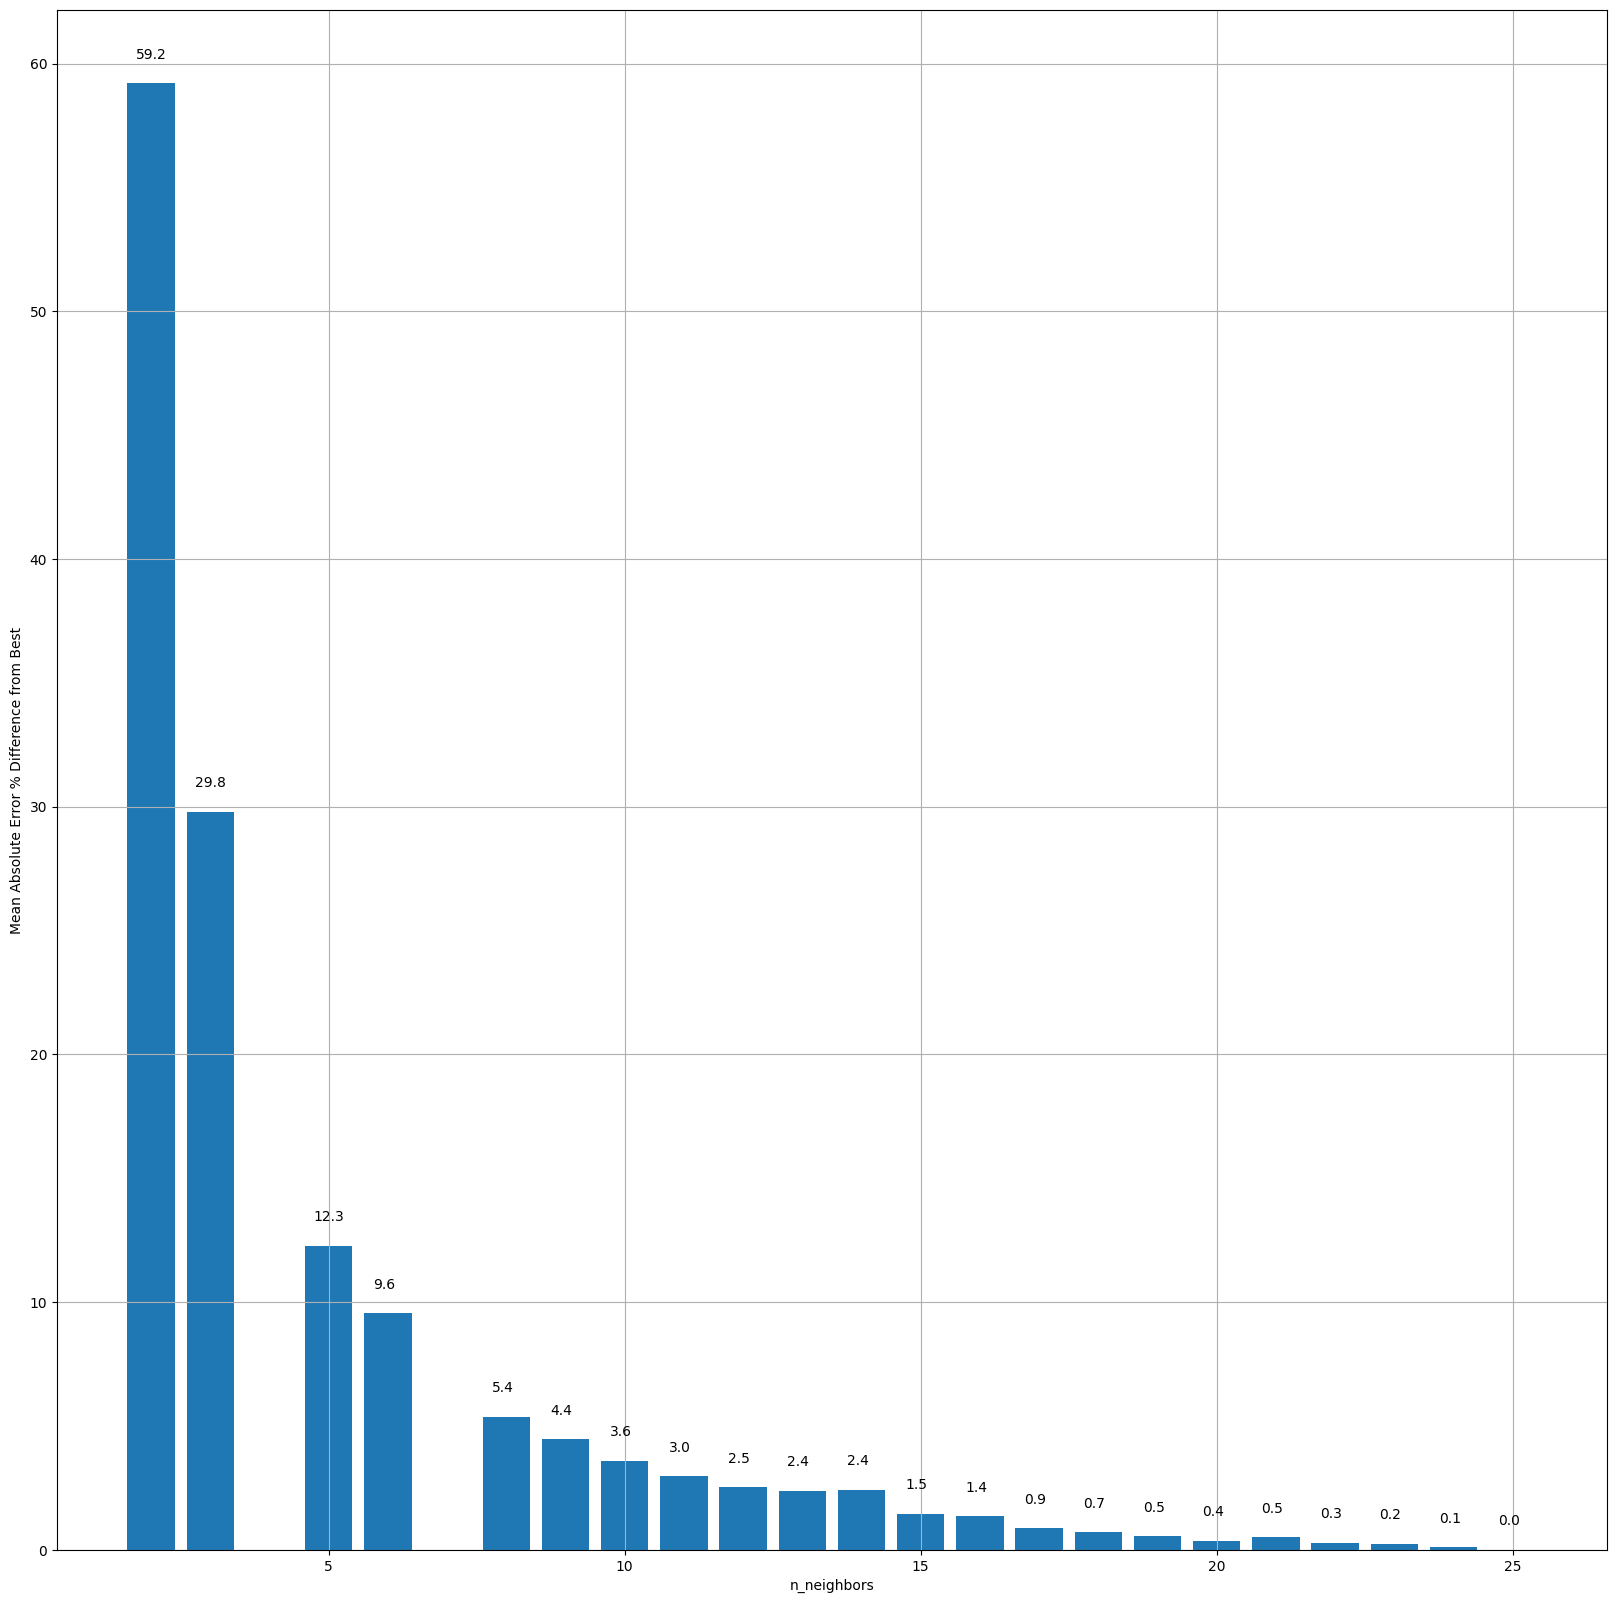

In [51]:
import matplotlib.pyplot as plt
import numpy as np

trial_list = trials.trials

# Extract the MAE scores from the trials
mae_scores = np.array([trial['result']['loss'] for trial in trial_list])

# Extract the n_neighbors values from the trials
n_neighbors_values = np.array([trial['misc']['vals']['n_neighbors'][0] for trial in trial_list])

# Get the unique n_neighbors values and their indices
unique_n_neighbors, indices = np.unique(n_neighbors_values, return_inverse=True)

# Calculate the average MAE score for each unique n_neighbors value
average_mae_scores = [mae_scores[indices == i].mean() for i in range(len(unique_n_neighbors))]

# Calculate the percentage difference of each MAE score from the best MAE score
best_score = min(average_mae_scores)
mae_scores_perc_diff = [100 * (x - best_score) / best_score for x in average_mae_scores]

# Plot
plt.bar(unique_n_neighbors, mae_scores_perc_diff)
# Show value over each bar centered above bar with 1% offset vertically
for i in range(len(unique_n_neighbors)):
    plt.text(x = unique_n_neighbors[i] - 0.25, y = mae_scores_perc_diff[i] + 1, s = round(mae_scores_perc_diff[i], 1))
plt.xlabel('n_neighbors')
plt.ylabel('Mean Absolute Error % Difference from Best')
plt.grid(True)
plt.show()


In [54]:
# Crea un modelo con los mejores hiperparámetros
model_knn= KNeighborsRegressor(n_neighbors=21,
                            weights='uniform',
                            p=1)

# Entrena el modelo
model_knn.fit(X_train_Modelling_SS, y_train)

KNeighborsRegressor(n_neighbors=21, p=1)

## LightGBM

In [289]:
import lightgbm as lgb
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_absolute_error

space ={
    'max_depth': hp.quniform('max_depth', 2, 12, 1),
    'learning_rate': hp.uniform('learning_rate', 0.015, 0.07),
    'num_leaves': hp.quniform('num_leaves', 5, 100, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.01, 1.0),
    'subsample': hp.uniform('subsample', 0.01, 1.0),
    'n_estimators': hp.quniform('n_estimators', 20, 300, 5),
    'min_child_samples': hp.quniform('min_child_samples', 2, 100, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0)
}

# Función objetivo para hyperopt
def objective(space):
    model_LGBM = lgb.LGBMRegressor(max_depth = int(space['max_depth']),
                             learning_rate = space['learning_rate'],
                             num_leaves = int(space['num_leaves']),
                             n_estimators = int(space['n_estimators']),
                             colsample_bytree = space['colsample_bytree'],
                             subsample = space['subsample'],
                             min_child_samples = int(space['min_child_samples']),
                             reg_alpha = space['reg_alpha'],
                             reg_lambda = space['reg_lambda'])
    
                             
    mae = cross_val_score(model_LGBM, X_train_Modelling_MC, y_train, cv=5, scoring=make_scorer(mean_absolute_error)).mean()

    return {'loss': mae, 'status': STATUS_OK}


# Run the algorithm
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=200,
            trials=trials)

print("Best: ", best)


100%|██████████| 200/200 [09:16<00:00,  2.78s/trial, best loss: 1.3985075026889007]
Best:  {'colsample_bytree': 0.7857887738902785, 'learning_rate': 0.03258780738912802, 'max_depth': 8.0, 'min_child_samples': 55.0, 'n_estimators': 240.0, 'num_leaves': 79.0, 'reg_alpha': 0.5301178811425332, 'reg_lambda': 0.028710808153810163, 'subsample': 0.8851558334026159}


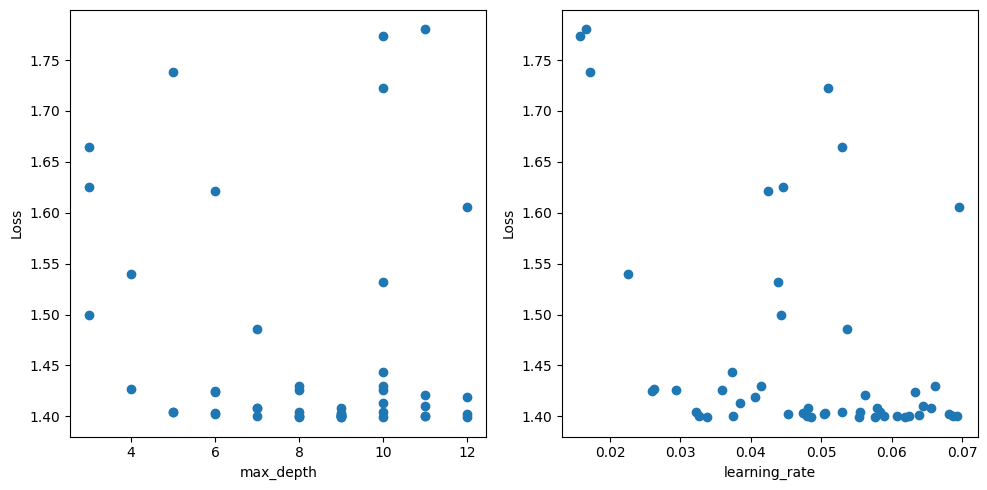

In [288]:
# Extrae los resultados
max_depth = [x['misc']['vals']['max_depth'] for x in trials.trials]
learning_rate = [x['misc']['vals']['learning_rate'] for x in trials.trials]
losses = [x['result']['loss'] for x in trials.trials]

# Grafica los resultados
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.scatter(max_depth, losses)
plt.xlabel('max_depth')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.scatter(learning_rate, losses)
plt.xlabel('learning_rate')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()


In [244]:
import lightgbm as lgb

# Creamos el modelo con los mejores hiperparámetros obtenidos
model_LGBM = lgb.LGBMRegressor(max_depth = int(best['max_depth']),
                          learning_rate = best['learning_rate'],
                          num_leaves = int(best['num_leaves']),
                          n_estimators = int(best['n_estimators']),
                          colsample_bytree = best['colsample_bytree'],
                          subsample = best['subsample'],
                          min_child_samples = int(best['min_child_samples']),
                          reg_alpha = best['reg_alpha'],
                          reg_lambda = best['reg_lambda'])


# Entrenamos el modelo con nuestros datos de entrenamiento
model_LGBM.fit(X_train_Modelling_MC, y_train)


LGBMRegressor(colsample_bytree=0.8235877962900493,
              learning_rate=0.056736988698903826, max_depth=9,
              min_child_samples=78, n_estimators=295, num_leaves=25,
              reg_alpha=0.7814520599301189, reg_lambda=0.7726806405170936,
              subsample=0.7680142497535167)

## Neural Network

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping


# asumiendo que X e y son tus datos y etiquetas respectivamente
# y que ya se encuentran preparados para entrenamiento

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_val, y_train, y_val = train_test_split(X_train_Modelling_MC, y_train, test_size=0.2, random_state=42)

# Normalizar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

early_stopping = EarlyStopping(monitor='val_loss', patience=10)


# Crear el modelo
model_NN = Sequential()
model_NN.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))  # Capa de entrada
model_NN.add(Dense(16, activation='relu'))  # Capa oculta
model_NN.add(Dense(1, activation='linear'))  # Capa de salida

# Compilar el modelo
model_NN.compile(loss='mean_absolute_error', optimizer='adam')

# Entrenar el modelo
history = model_NN.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=64, callbacks=[early_stopping])

Epoch 1/100
843/843 [==============================] - 2s 2ms/step - loss: 2.0463 - val_loss: 1.2576
Epoch 2/100
843/843 [==============================] - 1s 1ms/step - loss: 1.2501 - val_loss: 1.2333
Epoch 3/100
843/843 [==============================] - 1s 1ms/step - loss: 1.2368 - val_loss: 1.2210
Epoch 4/100
843/843 [==============================] - 1s 1ms/step - loss: 1.2291 - val_loss: 1.2235
Epoch 5/100
843/843 [==============================] - 1s 1ms/step - loss: 1.2278 - val_loss: 1.2258
Epoch 6/100
843/843 [==============================] - 1s 1ms/step - loss: 1.2257 - val_loss: 1.2177
Epoch 7/100
843/843 [==============================] - 1s 1ms/step - loss: 1.2238 - val_loss: 1.2262
Epoch 8/100
843/843 [==============================] - 1s 1ms/step - loss: 1.2225 - val_loss: 1.2136
Epoch 9/100
843/843 [==============================] - 1s 1ms/step - loss: 1.2219 - val_loss: 1.2294
Epoch 10/100
843/843 [==============================] - 1s 1ms/step - loss: 1.2220 - val_lo

In [ ]:
# Evaluar el modelo
train_mae = model.evaluate(X_train, y_train, verbose=0)
val_mae = model.evaluate(X_val, y_val, verbose=0)

print(f"Train MAE: {train_mae}")
print(f"Validation MAE: {val_mae}")

Train MAE: 0.029811784625053406
Validation MAE: 0.02982877381145954


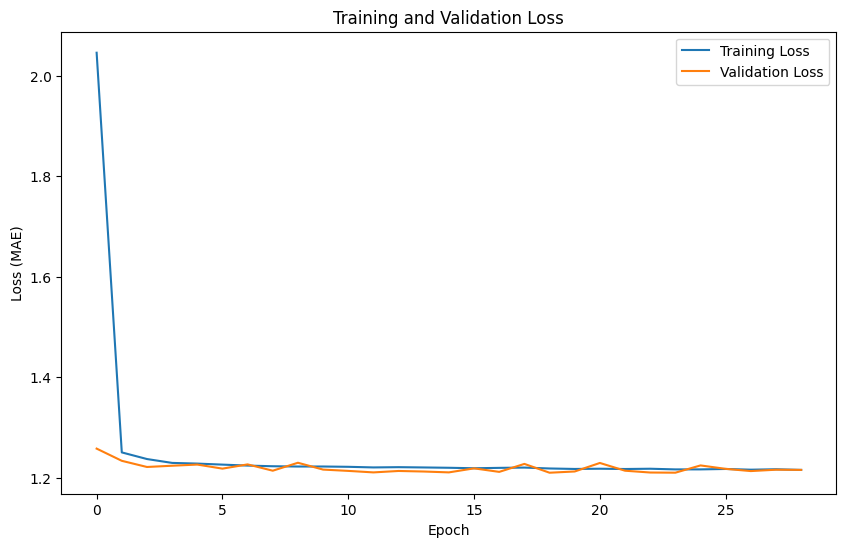

In [101]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.legend()
plt.show()

In [152]:
model_NN.fit(X_train_Modelling_SS, y_train, epochs=25, batch_size=64)

Epoch 1/25
1054/1054 [==============================] - 1s 1ms/step - loss: 1.2042
Epoch 2/25
1054/1054 [==============================] - 1s 1ms/step - loss: 1.2042
Epoch 3/25
1054/1054 [==============================] - 1s 1ms/step - loss: 1.2031
Epoch 4/25
1054/1054 [==============================] - 1s 1ms/step - loss: 1.2032
Epoch 5/25
1054/1054 [==============================] - 1s 1ms/step - loss: 1.2028
Epoch 6/25
1054/1054 [==============================] - 1s 1ms/step - loss: 1.2036
Epoch 7/25
1054/1054 [==============================] - 1s 1ms/step - loss: 1.2032
Epoch 8/25
1054/1054 [==============================] - 1s 1ms/step - loss: 1.2035
Epoch 9/25
1054/1054 [==============================] - 1s 1ms/step - loss: 1.2032
Epoch 10/25
1054/1054 [==============================] - 1s 1ms/step - loss: 1.2027
Epoch 11/25
1054/1054 [==============================] - 1s 1ms/step - loss: 1.2028
Epoch 12/25
1054/1054 [==============================] - 1s 1ms/step - loss: 1.2033
E

In [154]:
X_test.describe()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Sex_F,Sex_I,Sex_M,Relation_DL,Relation_HL,Relation_HD,Volume,Density,Ratio_ShuWei,Ratio_VisWei,Ratio_SheWei
count,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000
mean,1.319795,1.026357,0.348693,23.464627,10.130220,5.072615,6.745876,0.313604,0.323347,0.363049,0.775045,0.262342,0.338582,0.142000,169.895615,0.431193,0.216816,0.292944
std,0.286950,0.236593,0.092259,12.641703,5.611779,2.791563,3.575650,0.463962,0.467759,0.480884,0.030844,0.030866,0.039394,0.078692,29.882239,0.078422,0.031132,0.041271
min,0.187500,0.137500,0.000000,0.056699,0.028349,0.014175,0.042524,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.084507,0.051643,0.046948
25%,1.162500,0.887500,0.300000,13.536886,5.740774,2.877474,3.968930,0.000000,0.000000,0.000000,0.758929,0.245455,0.317460,0.080160,155.302527,0.397974,0.198827,0.267559
50%,1.387500,1.075000,0.362500,23.813580,9.979024,4.989512,6.945627,0.000000,0.000000,0.000000,0.776596,0.261538,0.337079,0.143090,167.005385,0.432040,0.215712,0.288873
75%,1.537500,1.200000,0.412500,32.290081,14.047177,7.016501,9.171063,1.000000,1.000000,1.000000,0.792308,0.278261,0.357143,0.198190,180.301513,0.463221,0.233428,0.314233
max,2.037500,1.625000,2.825000,80.101512,42.184056,21.545620,28.491248,1.000000,1.000000,1.000000,2.027027,2.483516,3.183099,0.876268,2297.005110,5.537313,2.146974,2.567766


In [155]:
# Inf values to 0
X_test = X_test.replace([np.inf, -np.inf], 0)

In [116]:
X_test_NN = scaler.fit_transform(X_test)

In [117]:
y_pred = model_NN.predict(X_test_NN)

1543/1543 [==============================] - 2s 916us/step


## XGBoost

In [59]:
import xgboost as xgb
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Definir el espacio de búsqueda de hiperparámetros
params = {
    'max_depth': hp.choice('max_depth', range(2, 7)),
    'learning_rate': hp.quniform('learning_rate', 0.01, 0.1, 0.01),
    'subsample': hp.quniform('subsample', 0.5, 0.8, 0.1),
    'gamma': hp.quniform('gamma', 0, 5, 0.5),
    'min_child_weight': hp.quniform('min_child_weight', 5, 15, 1),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.1),
    'reg_alpha': hp.quniform('reg_alpha', 0.5, 1, 0.1),
    'reg_lambda': hp.quniform('reg_lambda', 1, 10, 0.5)
}

# Dividir los datos de entrenamiento en un conjunto de entrenamiento y validación
X_train_MC, X_val, y_train_MC, y_val = train_test_split(X_train_Modelling_MC, y_train, test_size=0.3, random_state=42)

# Convertir los datos de entrenamiento y validación en objetos DMatrix
dtrain = xgb.DMatrix(X_train_MC, label=y_train_MC)
dvalid = xgb.DMatrix(X_val, label=y_val)

# Función objetivo para Hyperopt
def objective(params):
    params['max_depth'] = int(params['max_depth'])
   
    # Ajustar el modelo usando la función 'train' en lugar de la función 'fit'
    # Esto es necesario para usar la función de early stopping
    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=5000,
        evals=[(dvalid, 'eval')],
        early_stopping_rounds=10,
        verbose_eval=100
    )

    y_pred = model.predict(dvalid)
    mae = mean_absolute_error(y_val, y_pred)

    return {'loss': mae, 'status': STATUS_OK}


# Ejecutar la optimización de hiperparámetros
trials = Trials()
best = fmin(
    fn=objective,
    space=params,
    algo=tpe.suggest,
    max_evals=20,
    trials=trials
)



[0]	eval-rmse:9.90419                                 
[100]	eval-rmse:4.21180                               
[200]	eval-rmse:2.55086                               
[300]	eval-rmse:2.18812                               
[400]	eval-rmse:2.11268                               
[500]	eval-rmse:2.09095                               
[600]	eval-rmse:2.08170                               
[700]	eval-rmse:2.07642                               
[800]	eval-rmse:2.07300                               
[900]	eval-rmse:2.07081                               
[1000]	eval-rmse:2.06936                              
[1100]	eval-rmse:2.06798                              
[1200]	eval-rmse:2.06699                              
[1300]	eval-rmse:2.06622                              
[1400]	eval-rmse:2.06552                              
[1500]	eval-rmse:2.06492                              
[1600]	eval-rmse:2.06432                              
[1700]	eval-rmse:2.06377                              
[1800]	eva

In [62]:
# Entrenar el modelo con los mejores hiperparámetros
model_XGB = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=int(best['max_depth']),
    learning_rate=best['learning_rate'],
    subsample=best['subsample'],
    gamma=best['gamma'],
    min_child_weight=best['min_child_weight'],
    colsample_bytree=best['colsample_bytree'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    random_state=42
)
model_XGB.fit(X_train_Modelling_MC, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=5.0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=7.0, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

# Stacking

## Option 1

In [140]:
X_train_Stack = scaler.transform(X_train_Modelling_MC)

In [162]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from mlxtend.regressor import StackingCVRegressor
from sklearn.metrics import mean_absolute_error, make_scorer    


linear_regression = XGBRegressor()

# Construir el modelo de Stacking
stacking_regressor = StackingCVRegressor(regressors=[model_knn, model_RF, model_LGBM, model_XGB, model_Lasso],
                                         meta_regressor=linear_regression,
                                         random_state=42,
                                         use_features_in_secondary=True)

# Entrenar todos los modelos
for clf in [model_knn, model_RF, model_LGBM, model_XGB, model_Lasso, stacking_regressor]:
    scores = cross_val_score(clf, X_train_Stack, y_train_MC, cv=5, scoring=make_scorer(mean_absolute_error))
    print(f"{clf.__class__.__name__}: {scores.mean()} ± {scores.std()}")


KNeighborsRegressor: 1.2764000462226965 ± 0.0
[LightGBM] [Warning] feature_fraction is set=0.5935125266901218, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5935125266901218
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] bagging_fraction is set=0.06711447241587068, subsample=1.0 will be ignored. Current value: bagging_fraction=0.06711447241587068
[LightGBM] [Warning] feature_fraction is set=0.5935125266901218, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5935125266901218
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] bagging_fraction is set=0.06711447241587068, subsample=1.0 will be ignored. Current value: bagging_fraction=0.06711447241587068
[LightGBM] [Warning] feature_fraction is set=0.5935125266901218, colsample_bytree=1.0 will be ignored. C

In [163]:
X_test.describe()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Sex_F,Sex_I,Sex_M,Relation_DL,Relation_HL,Relation_HD,Volume,Density,Ratio_ShuWei,Ratio_VisWei,Ratio_SheWei
count,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000
mean,1.319795,1.026357,0.348693,23.464627,10.130220,5.072615,6.745876,0.313604,0.323347,0.363049,0.775045,0.262342,0.338582,0.142000,169.895615,0.431193,0.216816,0.292944
std,0.286950,0.236593,0.092259,12.641703,5.611779,2.791563,3.575650,0.463962,0.467759,0.480884,0.030844,0.030866,0.039394,0.078692,29.882239,0.078422,0.031132,0.041271
min,0.187500,0.137500,0.000000,0.056699,0.028349,0.014175,0.042524,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.084507,0.051643,0.046948
25%,1.162500,0.887500,0.300000,13.536886,5.740774,2.877474,3.968930,0.000000,0.000000,0.000000,0.758929,0.245455,0.317460,0.080160,155.302527,0.397974,0.198827,0.267559
50%,1.387500,1.075000,0.362500,23.813580,9.979024,4.989512,6.945627,0.000000,0.000000,0.000000,0.776596,0.261538,0.337079,0.143090,167.005385,0.432040,0.215712,0.288873
75%,1.537500,1.200000,0.412500,32.290081,14.047177,7.016501,9.171063,1.000000,1.000000,1.000000,0.792308,0.278261,0.357143,0.198190,180.301513,0.463221,0.233428,0.314233
max,2.037500,1.625000,2.825000,80.101512,42.184056,21.545620,28.491248,1.000000,1.000000,1.000000,2.027027,2.483516,3.183099,0.876268,2297.005110,5.537313,2.146974,2.567766


In [166]:
X_test.describe()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Sex_F,Sex_I,Sex_M,Relation_DL,Relation_HL,Relation_HD,Volume,Density,Ratio_ShuWei,Ratio_VisWei,Ratio_SheWei
count,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000
mean,1.319795,1.026357,0.348693,23.464627,10.130220,5.072615,6.745876,0.313604,0.323347,0.363049,0.775045,0.262342,0.338582,0.142000,169.895615,0.431193,0.216816,0.292944
std,0.286950,0.236593,0.092259,12.641703,5.611779,2.791563,3.575650,0.463962,0.467759,0.480884,0.030844,0.030866,0.039394,0.078692,29.882239,0.078422,0.031132,0.041271
min,0.187500,0.137500,0.000000,0.056699,0.028349,0.014175,0.042524,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.084507,0.051643,0.046948
25%,1.162500,0.887500,0.300000,13.536886,5.740774,2.877474,3.968930,0.000000,0.000000,0.000000,0.758929,0.245455,0.317460,0.080160,155.302527,0.397974,0.198827,0.267559
50%,1.387500,1.075000,0.362500,23.813580,9.979024,4.989512,6.945627,0.000000,0.000000,0.000000,0.776596,0.261538,0.337079,0.143090,167.005385,0.432040,0.215712,0.288873
75%,1.537500,1.200000,0.412500,32.290081,14.047177,7.016501,9.171063,1.000000,1.000000,1.000000,0.792308,0.278261,0.357143,0.198190,180.301513,0.463221,0.233428,0.314233
max,2.037500,1.625000,2.825000,80.101512,42.184056,21.545620,28.491248,1.000000,1.000000,1.000000,2.027027,2.483516,3.183099,0.876268,2297.005110,5.537313,2.146974,2.567766


In [167]:
X_train_Modelling_MC.describe()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Sex_F,Sex_I,Sex_M,Relation_DL,Relation_HL,Relation_HD,Volume,Density,Ratio_ShuWei,Ratio_VisWei,Ratio_SheWei
count,67429.000000,67429.000000,67429.000000,67429.000000,67429.000000,67429.000000,67429.000000,67429.000000,67429.000000,67429.000000,67429.000000,67429.000000,67429.000000,67429.000000,67429.000000,67429.000000,67429.000000,67429.000000
mean,1.326047,1.031066,0.348965,22.977382,9.980035,4.981683,6.589098,0.310163,0.319506,0.370330,0.775726,0.261972,0.337789,0.139007,168.640412,0.433930,0.216921,0.291896
std,0.248569,0.206025,0.079508,11.240448,5.036580,2.506184,3.145124,0.462564,0.466289,0.482897,0.027491,0.025315,0.031277,0.070580,19.865879,0.073034,0.027752,0.037755
min,0.600000,0.500000,0.150000,1.105630,0.666213,0.226796,0.311845,0.000000,0.000000,0.000000,0.373239,0.119718,0.187500,0.012026,52.564923,0.193277,0.076023,0.122155
25%,1.175000,0.900000,0.300000,13.806207,5.910871,2.934173,4.110678,0.000000,0.000000,0.000000,0.759615,0.245455,0.317073,0.082405,155.541209,0.402398,0.199667,0.267677
50%,1.375000,1.075000,0.362500,23.515910,9.865626,4.918638,6.803880,0.000000,0.000000,0.000000,0.776699,0.260870,0.336735,0.140365,166.885461,0.434211,0.216086,0.288387
75%,1.525000,1.187500,0.412500,31.623867,13.877080,6.903103,8.930093,1.000000,1.000000,1.000000,0.792000,0.277311,0.355769,0.192623,179.573723,0.464228,0.233372,0.312862
max,1.937500,1.500000,0.562500,54.062497,23.331639,11.538246,14.897662,1.000000,1.000000,1.000000,1.000000,0.453608,0.602740,0.386862,384.085574,4.725118,0.665399,2.615672


In [168]:
stacking_regressor.fit(X_train_Modelling_MC, y_train_MC)
y_pred = stacking_regressor.predict(X_test)  

[LightGBM] [Warning] feature_fraction is set=0.5935125266901218, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5935125266901218
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] bagging_fraction is set=0.06711447241587068, subsample=1.0 will be ignored. Current value: bagging_fraction=0.06711447241587068
[LightGBM] [Warning] feature_fraction is set=0.5935125266901218, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5935125266901218
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] bagging_fraction is set=0.06711447241587068, subsample=1.0 will be ignored. Current value: bagging_fraction=0.06711447241587068
[LightGBM] [Warning] feature_fraction is set=0.5935125266901218, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5935125266901

c:\Users\Jose\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
c:\Users\Jose\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(


In [100]:
y_pred = model_LGBM.predict(X_test)

In [29]:
X_train_OHE.head()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,Sex_F,Sex_I,Sex_M
0,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9,0,1,0
1,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8,0,1,0
2,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9,0,0,1
3,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11,1,0,0
4,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8,0,1,0


In [38]:
# Extrae la columna 'Age' como tu vector objetivo y luego elimínala de X_train_OHE
y_train = X_train_OHE['Age']
X_train_OHE = X_train_OHE.drop(columns='Age')


,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Sex_F,Sex_I,Sex_M
0,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,0,1,0
1,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,0,1,0
2,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,0,0,1
3,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,1,0,0
4,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,0,1,0


## Option 2

In [73]:
y= y_train
X= X_train_Modelling_MC

In [75]:
from sklearn.model_selection import KFold
import numpy as np

# Inicializa los modelos
models = [model_knn, model_RF, model_LGBM, model_XGB, model_Lasso]

# Inicializa KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Para almacenar las predicciones OOF de cada modelo
oof_predictions = np.zeros((X.shape[0], len(models)))

# Convierte los DataFrames a arrays de NumPy
X_np = X.values
y_np = y.values

# Entrena cada modelo
for i, model in enumerate(models):
    for train_index, test_index in kf.split(X):
        # Divide los datos en entrenamiento y prueba
        X_train, X_test = X_np[train_index], X_np[test_index]
        y_train, y_test = y_np[train_index], y_np[test_index]

        # Entrena el modelo
        model.fit(X_train, y_train)

        # Genera las predicciones OOF
        oof_predictions[test_index, i] = model.predict(X_test)

In [76]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

# Define el espacio de búsqueda de hiperparámetros
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 10),
    'learning_rate': hp.uniform('learning_rate', 0.0001, 0.05),
    'max_depth':  hp.choice('max_depth', np.arange(2, 24, dtype=int)),
    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'gamma': hp.uniform('gamma', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1)
}

# Define la función objetivo
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'learning_rate': params['learning_rate'],
        'max_depth': params['max_depth'],
        'min_child_weight': params['min_child_weight'],
        'subsample': params['subsample'],
        'gamma': params['gamma'],
        'colsample_bytree': params['colsample_bytree'],
    }
    
    model = XGBRegressor(**params)
    score = cross_val_score(model, oof_predictions, y, scoring='neg_mean_squared_error', cv=5, n_jobs=-1).mean()
    return {'loss': -score, 'status': STATUS_OK}

# Ejecuta la optimización
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)


100%|██████████| 20/20 [32:45<00:00, 98.26s/trial, best loss: 4.182116779344621] 


In [77]:
# Convierte 'n_estimators' a int
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = np.arange(1, 14, dtype=int)[best['max_depth']]

# Entrena el modelo de segundo nivel con los mejores hiperparámetros
second_level_model = XGBRegressor(**best)
second_level_model.fit(oof_predictions, y)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9506658838357855, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.5844147318986224, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.010971396780106444, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=2.0, missing=nan, monotone_constraints=None,
             n_estimators=390, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
X_test = pd.read_csv('input/test.csv')
X_test.drop(columns='id', inplace=True)

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
0,I,1.0500,0.7625,0.2750,8.618248,3.657085,1.729319,2.721552
1,I,1.1625,0.8875,0.2750,15.507176,7.030676,3.246018,3.968930
2,F,1.2875,0.9875,0.3250,14.571643,5.556502,3.883882,4.819415
3,F,1.5500,0.9875,0.3875,28.377849,13.380964,6.548735,7.030676
4,I,1.1125,0.8500,0.2625,11.765042,5.528153,2.466407,3.331066


In [ ]:
X_test = pd.concat([X_test, pd.get_dummies(X_test['Sex'], prefix='Sex')], axis=1)
X_test.drop('Sex', axis=1, inplace=True)

In [251]:
X_test.head()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Sex_F,Sex_I,Sex_M
0,1.0500,0.7625,0.2750,8.618248,3.657085,1.729319,2.721552,0,1,0
1,1.1625,0.8875,0.2750,15.507176,7.030676,3.246018,3.968930,0,1,0
2,1.2875,0.9875,0.3250,14.571643,5.556502,3.883882,4.819415,1,0,0
3,1.5500,0.9875,0.3875,28.377849,13.380964,6.548735,7.030676,1,0,0
4,1.1125,0.8500,0.2625,11.765042,5.528153,2.466407,3.331066,0,1,0


In [134]:
X_test.drop('id', axis=1, inplace=True)

In [252]:
y_pred = model_LGBM.predict(X_test)

In [248]:
X_test.describe()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
count,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000
mean,1.319795,1.026357,0.348693,23.464627,10.130220,5.072615,6.745876
std,0.286950,0.236593,0.092259,12.641703,5.611779,2.791563,3.575650
min,0.187500,0.137500,0.000000,0.056699,0.028349,0.014175,0.042524
25%,1.162500,0.887500,0.300000,13.536886,5.740774,2.877474,3.968930
50%,1.387500,1.075000,0.362500,23.813580,9.979024,4.989512,6.945627
75%,1.537500,1.200000,0.412500,32.290081,14.047177,7.016501,9.171063
max,2.037500,1.625000,2.825000,80.101512,42.184056,21.545620,28.491248


In [136]:
# Inicializa una matriz para almacenar las predicciones de primer nivel para X_test
test_predictions = np.zeros((X_test.shape[0], len(models)))

# Genera las predicciones de primer nivel para X_test
for i, model in enumerate(models):
    test_predictions[:, i] = model.predict(X_test)

# Usa el modelo de segundo nivel para generar las predicciones finales
y_pred = second_level_model.predict(test_predictions)


c:\Users\Jose\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
c:\Users\Jose\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
c:\Users\Jose\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(


In [ ]:
X_test.head()

In [ ]:
y_pred = model_LGBM.predict(X_test)

# Submission

In [ ]:
X_test

In [207]:
y_pred = X_test['Age']

In [130]:
X_test_submission = pd.read_csv('input/test.csv') # Test data

In [131]:
id_test = X_test_submission['id']

In [133]:
y_pred = X_test_remain2['Age']

In [134]:
# Submission to a file
# Rounded pred increases the score
submission = pd.DataFrame({'id': id_test, 'Age': y_pred})
submission.to_csv('submission.csv', index=False)


In [124]:
# Copy of X_test_remain
X_test_remain2 = X_test_remain.copy()

In [125]:
# Data import 
X_original = pd.read_csv('input/CrabAgePrediction.csv')
X_train1, X_test1  = dataset(0, 0, 0)

In [126]:
# One Hot enconding of sex feature of X_test
X_original = pd.concat([X_original, pd.get_dummies(X_original['Sex'], prefix='Sex')], axis=1)
X_original.drop('Sex', axis=1, inplace=True)

# The same for the test data   
X_original['Sex_F'] = X_original['Sex_F'].astype(int)
X_original['Sex_M'] = X_original['Sex_M'].astype(int)
X_original['Sex_I'] = X_original['Sex_I'].astype(int)

In [144]:
X_original.to_csv('data/X_original_OHE.csv', index=False)

In [113]:
# Step 1: Find coincidence between X_original and X_test and fill those 'Age' values in the case
X_test_coinc= X_test1.loc[:, ["Length", "Diameter", "Height", "Weight", "Shucked Weight", "Viscera Weight","Shell Weight", "Sex_F", "Sex_I", "Sex_M"]]

# Add the 'Age' column to X_test
columns_without_age = [col for col in X_test_coinc.columns]

# Find coincidence between X_original and X_test and fill those 'Age' values in the case, in the rest Nan values
X_test_remain2 = X_test_remain2.merge(X_original, how='left', on=columns_without_age)

In [127]:
cols = ["Length", "Diameter", "Height", "Weight", "Shucked Weight", "Viscera Weight","Shell Weight", "Sex_F", "Sex_I", "Sex_M"]

# Asegúrate de que 'Age' es el índice en X_original
X_original.set_index(cols, inplace=True)

# Asegúrate de que 'Age' es el índice en X_test_remain2
X_test_remain2.set_index(cols, inplace=True)

# Actualiza 'Age' en X_test_remain2 con los valores de X_original
X_test_remain2['Age'].update(X_original['Age'])

# Restablece el índice en ambos DataFrames
X_original.reset_index(inplace=True)
X_test_remain2.reset_index(inplace=True)

In [142]:
differences = X_test_remain2.compare(X_test_remain)

# Muestra las filas que son diferentes
print(differences)

        Age      
       self other
92     10.0  13.0
417     7.0   9.0
421     9.0  13.0
602     5.0   6.0
648     8.0  11.0
...     ...   ...
48944  16.0  12.0
49163   9.0  10.0
49179   9.0  11.0
49196   7.0   8.0
49365  12.0  13.0

[547 rows x 2 columns]


In [138]:
X_test_remain.iloc[92]

Length             1.612500
Diameter           1.337500
Height             0.475000
Weight            35.139205
Shucked Weight    13.267566
Viscera Weight     6.761356
Shell Weight      12.020188
Sex_F              1.000000
Sex_I              0.000000
Sex_M              0.000000
Age               13.000000
Name: 92, dtype: float64

In [139]:
X_test_remain2.iloc[92]

Length             1.612500
Diameter           1.337500
Height             0.475000
Weight            35.139205
Shucked Weight    13.267566
Viscera Weight     6.761356
Shell Weight      12.020188
Sex_F              1.000000
Sex_I              0.000000
Sex_M              0.000000
Age               10.000000
Name: 92, dtype: float64

In [140]:
X_Z = pd.concat([X_test_remain2, id_test], axis=1)

In [143]:
X_Z.iloc[92]

Length                1.612500
Diameter              1.337500
Height                0.475000
Weight               35.139205
Shucked Weight       13.267566
Viscera Weight        6.761356
Shell Weight         12.020188
Sex_F                 1.000000
Sex_I                 0.000000
Sex_M                 0.000000
Age                  10.000000
id                74143.000000
Name: 92, dtype: float64